In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs.gf import Fourier
from h5 import *
import triqs.utility.mpi as mpi

from triqs.operators import *
from triqs_cthyb import Solver

from triqs.plot.mpl_interface import oplot,plt
from triqs.gf import MeshImTime
from triqs.gf import GfImFreq, GfImTime, make_gf_from_fourier

from triqs.gf import  MeshImTime, MeshReFreq, Gf
from triqs.plot.mpl_interface import oplot, plt

from multiprocessing import Pool
from itertools import repeat
from functools import partial

import csv
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

# from pymatgen.electronic_structure.plotter import BSDOSPlotter, BSPlotter, DosPlotter
# from pymatgen.io.vasp.outputs import BSVasprun, Vasprun

import pickle 
from  tqdm import tqdm

%load_ext autoreload
%autoreload 2
import sys
import torch
import torch.nn as nn
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

sys.path.append("./src")
# import DataBase
# import ml_model
# import Sample 
from band_generation import Band_generator
from util import * 
from ml_model import MLSolver    


import Sample

# %matplotlib inline


Starting serial run at: 2024-10-30 10:08:45.309815


In [3]:
def predict_G(sample):
    gl = np.real(sample.G0_l.data).flatten()
    beta = sample.beta
    U = sample.U
    features = np.hstack([U, beta, gl])
    leg = MLmodel(torch.Tensor(features)).cpu().detach().numpy()

    meshQ = MeshLegendre(beta, 'Fermion', 30)
    Gpredicted = Gf(mesh=meshQ, target_shape=[1,1])
    Gpredicted.data[:] = leg[:, np.newaxis, np.newaxis]

    tau_mesh = MeshImTime(beta=beta, statistic='Fermion', n_tau=sample.n_tau)
    GtauML = Gf(mesh=tau_mesh, target_shape=[1,1])
    GtauML.set_from_legendre(Gpredicted)

    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=sample.n_iw)
    G_iw_ML = Gf(mesh=iw_mesh, target_shape=[1,1])
    G_iw_ML.set_from_legendre(Gpredicted)

    return G_iw_ML, GtauML, Gpredicted #leg

# G_iw_ML, GtauML, Gpredicted = predict_G(s)

def plot_all(sample,  A0ens, A0, Aens, A, Aens_ML, A_ML, sigma=0.2):

    G_iw_ML, GtauML, Gl_ML = predict_G(sample)


    fig = plt.figure(constrained_layout=True, figsize=( 4, 4))
    # axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
    #                         gridspec_kw={'width_ratios':[2, 1]})
    
    axs = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                            gridspec_kw={'width_ratios':[2, 1]})
    # axs['Top'].set_title('Spectral function')


    energy_min = -3  # Minimum energy value
    energy_max = 3  # Maximum energy value
    n_points = 100   # Number of points in the energy grid
    energy_grid = np.linspace(energy_min, energy_max, n_points)

    dos = np.zeros_like(energy_grid)

    # for energy in sample.BS.flatten():
    #     dos += gaussian(energy_grid, energy, sigma)
    # dos_integral = np.trapz(dos, energy_grid)  # Compute the integral of the DOS
    # dos /= dos_integral  # Normalize the DOS
    # axs['Top'].plot(energy_grid, dos, label=f'Gaussian Broadened DOS (sigma={sigma})')

    # A0ens, A0 =  get_Gw(sample.G0_tau)
    axs['Top'].plot(A0ens, A0, 'b', label=r'-$\frac{1}{\pi}$ Im $G_0$')
    
    # Aens, A =  get_Gw(sample.G_tau)
    axs['Top'].plot(Aens, A, 'orange', label=r'-$\frac{1}{\pi}$ Im $G$')

    # Aens_ML, A_ML =  get_Gw(GtauML)
    axs['Top'].plot(Aens_ML, A_ML, 'r', label=r'-$\frac{1}{\pi}$ Im $G_{ML}$')

    axs['Top'].set_xlim((-1, 1))
    axs['Top'].set_ylim((0, max(np.max(A0)*1.5,  np.max(A0)*1.5) ))
    axs['Top'].set_xlabel(r'$E - E_f$(eV)')
    axs['Top'].set_ylabel('Density of States (DOS)')
    axs['Top'].text(-0.13, 1.0, 'a)', transform=axs['Top'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    axs['Top'].legend(prop={'size': 10}, frameon=False)  

    # plt.legend()

    #################################################################################################    
    # axs['BottomLeft'].set_title('Plot Top Right')

    ntau = 200
    taumesh = np.linspace(0, sample.beta, ntau)
    G0_rebinned = sample.G0_tau.rebinning_tau(new_n_tau=ntau)
    G_rebinned = sample.G_tau.rebinning_tau(new_n_tau=ntau)
    GML_rebinned = GtauML.rebinning_tau(new_n_tau=ntau)


    axs['BottomLeft'].plot(taumesh, np.real(G_rebinned.data.flatten()),  'orange', label='G')
    axs['BottomLeft'].plot(taumesh, np.real(G0_rebinned.data.flatten()), 'b', label='G0')
    axs['BottomLeft'].plot(taumesh, np.real(GML_rebinned.data.flatten()), 'r', label='G ML')

    axs['BottomLeft'].set_xlabel(r'$\tau$(eV)')
    axs['BottomLeft'].set_ylabel(r'$G(\tau)$ (eV$^{-1}$)')
    axs['BottomLeft'].set_xlim((0, sample.beta))
    
    axs['BottomLeft'].text(-0.2, 1.0, 'b)', transform=axs['BottomLeft'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    #################################################################################################    
    # axs['BottomRight'].set_title('Legendre')
    xs = np.arange(0, 30, 1)
    axs['BottomRight'].scatter(xs, np.real(sample.G0_l.data.flatten())[:30], c='b', marker='D', label='G0')
    axs['BottomRight'].scatter(xs, np.real(sample.G_l.data.flatten())[:30], c='orange',  marker='s', label='G')
    axs['BottomRight'].scatter(xs, np.real(Gl_ML.data.flatten())[:30], c='r',  marker='x', label='G ML')

    axs['BottomRight'].set_xlabel('n')
    axs['BottomRight'].set_ylabel(r'$G_l$')
    axs['BottomRight'].set_xlim((0, 10))
    
    
    axs['BottomRight'].text(-0.2, 1.0, 'c)', transform=axs['BottomRight'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    
    plt.savefig('./sample.pdf', dpi=200, bbox_inches='tight')

    plt.show()


In [33]:
bg = Band_generator()
bg.load_checkpoint('./models/AUTOmodel_v4')
BS = bg.getBS().flatten()      

model_path='./models/model_v2'
MLmodel = MLSolver().to(device, torch.float32)
MLmodel.load_checkpoint(checkpoint_path=model_path)


model loaded from ./models/AUTOmodel_v4
model loaded from ./models/model_v2


# Perfomance test

In [22]:
betas = np.linspace(5, 20, 10)
Us = np.linspace(1, 5, 10)
params = np.reshape(np.array(np.meshgrid(betas, Us)), (2, -1)) 

beta    = (params.T)[:, 0]
U       = (params.T)[:, 1]


In [13]:
results = []
for beta, U in tqdm(params.T):
    print(beta, U)
    s = Sample.sample(beta=beta,U=U, BS=BS)
    s.solve_impurity()
    results.append([s.time2solve, s.averageorder])

beta    = (params.T)[:, 0]
U       = (params.T)[:, 1]
time    = np.array([x[0] for x in results])
order   = np.array([x[1] for x in results])

 

  0%|          | 0/100 [00:00<?, ?it/s]

5.0 1.0


  1%|          | 1/100 [00:15<25:35, 15.51s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:05:45   0% ETA 00:00:17 cycle 57 of 10000
12:05:47  15% ETA 00:00:11 cycle 1571 of 10000
12:05:49  34% ETA 00:00:08 cycle 3464 of 10000
12:05:52  57% ETA 00:00:05 cycle 5798 of 10000
12:05:56  87% ETA 00:00:01 cycle 8780 of 10000
12:05:58 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:05:58  15% ETA 00:00:00 cycle 76 of 500
12:05:59 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000919397
Average order         | 0.000637589
Average sign         

  2%|▏         | 2/100 [00:35<29:10, 17.86s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:06:00   0% ETA 00:00:21 cycle 47 of 10000
12:06:02  12% ETA 00:00:15 cycle 1224 of 10000
12:06:05  27% ETA 00:00:12 cycle 2711 of 10000
12:06:08  45% ETA 00:00:09 cycle 4559 of 10000
12:06:12  68% ETA 00:00:05 cycle 6844 of 10000
12:06:17  97% ETA 00:00:00 cycle 9727 of 10000
12:06:17 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:06:17  11% ETA 00:00:00 cycle 56 of 500
12:06:18 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00106511
Average ord

  3%|▎         | 3/100 [00:57<32:29, 20.10s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:06:20   0% ETA 00:00:21 cycle 46 of 10000
12:06:22  10% ETA 00:00:18 cycle 1021 of 10000
12:06:24  22% ETA 00:00:15 cycle 2282 of 10000
12:06:27  38% ETA 00:00:12 cycle 3852 of 10000
12:06:31  58% ETA 00:00:08 cycle 5812 of 10000
12:06:36  82% ETA 00:00:03 cycle 8263 of 10000
12:06:40 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:06:40   8% ETA 00:00:01 cycle 42 of 500
12:06:41 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000976116
Average or

  4%|▍         | 4/100 [01:22<35:16, 22.04s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:06:42   0% ETA 00:00:24 cycle 40 of 10000
12:06:44   9% ETA 00:00:20 cycle 954 of 10000
12:06:47  20% ETA 00:00:17 cycle 2087 of 10000
12:06:50  35% ETA 00:00:14 cycle 3499 of 10000
12:06:54  52% ETA 00:00:10 cycle 5262 of 10000
12:06:59  74% ETA 00:00:05 cycle 7456 of 10000
12:07:05 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:07:05   9% ETA 00:00:01 cycle 44 of 500
12:07:06 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00106306
Average orde

  5%|▌         | 5/100 [01:48<37:15, 23.53s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:07:07   0% ETA 00:00:25 cycle 39 of 10000
12:07:09   9% ETA 00:00:21 cycle 900 of 10000
12:07:12  19% ETA 00:00:18 cycle 1984 of 10000
12:07:15  33% ETA 00:00:15 cycle 3322 of 10000
12:07:19  50% ETA 00:00:11 cycle 5003 of 10000
12:07:24  71% ETA 00:00:06 cycle 7101 of 10000
12:07:30  97% ETA 00:00:00 cycle 9720 of 10000
12:07:31 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:07:31   8% ETA 00:00:01 cycle 42 of 500
12:07:32 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


  6%|▌         | 6/100 [02:16<38:56, 24.85s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:07:34   0% ETA 00:00:29 cycle 33 of 10000
12:07:36   8% ETA 00:00:22 cycle 861 of 10000
12:07:38  18% ETA 00:00:19 cycle 1889 of 10000
12:07:41  31% ETA 00:00:16 cycle 3161 of 10000
12:07:45  47% ETA 00:00:13 cycle 4752 of 10000
12:07:50  67% ETA 00:00:08 cycle 6757 of 10000
12:07:56  92% ETA 00:00:01 cycle 9269 of 10000
12:07:58 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:07:58   8% ETA 00:00:01 cycle 39 of 500
12:07:59 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


  7%|▋         | 7/100 [02:44<40:13, 25.95s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:08:01   0% ETA 00:00:30 cycle 32 of 10000
12:08:03   8% ETA 00:00:23 cycle 835 of 10000
12:08:06  18% ETA 00:00:20 cycle 1835 of 10000
12:08:09  30% ETA 00:00:17 cycle 3077 of 10000
12:08:13  46% ETA 00:00:13 cycle 4637 of 10000
12:08:18  65% ETA 00:00:08 cycle 6584 of 10000
12:08:24  90% ETA 00:00:02 cycle 9002 of 10000
12:08:26 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:08:26   7% ETA 00:00:01 cycle 37 of 500
12:08:28 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


  8%|▊         | 8/100 [03:13<41:22, 26.98s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:08:29   0% ETA 00:00:28 cycle 35 of 10000
12:08:31   8% ETA 00:00:23 cycle 815 of 10000
12:08:34  17% ETA 00:00:21 cycle 1772 of 10000
12:08:37  29% ETA 00:00:18 cycle 2978 of 10000
12:08:41  44% ETA 00:00:14 cycle 4467 of 10000
12:08:46  63% ETA 00:00:09 cycle 6302 of 10000
12:08:52  86% ETA 00:00:03 cycle 8625 of 10000
12:08:56 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:08:56   8% ETA 00:00:01 cycle 39 of 500
12:08:57 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


  9%|▉         | 9/100 [03:43<42:11, 27.82s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:08:58   0% ETA 00:00:34 cycle 29 of 10000
12:09:00   7% ETA 00:00:25 cycle 777 of 10000
12:09:03  17% ETA 00:00:22 cycle 1717 of 10000
12:09:06  29% ETA 00:00:19 cycle 2911 of 10000
12:09:10  43% ETA 00:00:15 cycle 4395 of 10000
12:09:15  62% ETA 00:00:09 cycle 6265 of 10000
12:09:21  85% ETA 00:00:03 cycle 8540 of 10000
12:09:25 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:09:25   7% ETA 00:00:01 cycle 37 of 500
12:09:26 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


 10%|█         | 10/100 [04:13<42:45, 28.51s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:09:28   0% ETA 00:00:34 cycle 29 of 10000
12:09:30   7% ETA 00:00:25 cycle 768 of 10000
12:09:33  17% ETA 00:00:22 cycle 1704 of 10000
12:09:36  28% ETA 00:00:19 cycle 2875 of 10000
12:09:40  43% ETA 00:00:15 cycle 4335 of 10000
12:09:45  61% ETA 00:00:10 cycle 6148 of 10000
12:09:51  84% ETA 00:00:04 cycle 8420 of 10000
12:09:55 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:09:55   7% ETA 00:00:01 cycle 37 of 500
12:09:57 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   


 11%|█         | 11/100 [04:28<36:00, 24.27s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:09:58   0% ETA 00:00:16 cycle 60 of 10000
12:10:00  16% ETA 00:00:10 cycle 1672 of 10000
12:10:03  36% ETA 00:00:08 cycle 3675 of 10000
12:10:06  62% ETA 00:00:04 cycle 6201 of 10000
12:10:10  93% ETA 00:00:00 cycle 9373 of 10000
12:10:11 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:10:11  15% ETA 00:00:00 cycle 75 of 500
12:10:11 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00093002
Average order         | 0.000637505
Average sign    

 12%|█▏        | 12/100 [04:46<33:10, 22.62s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:10:13   0% ETA 00:00:20 cycle 47 of 10000
12:10:15  12% ETA 00:00:14 cycle 1257 of 10000
12:10:17  27% ETA 00:00:12 cycle 2792 of 10000
12:10:20  47% ETA 00:00:08 cycle 4715 of 10000
12:10:24  71% ETA 00:00:04 cycle 7110 of 10000
12:10:29 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:10:29  12% ETA 00:00:00 cycle 60 of 500
12:10:30 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000962  
Average order         | 0.000645549
Average sign    

 13%|█▎        | 13/100 [05:09<32:34, 22.47s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:10:32   0% ETA 00:00:23 cycle 41 of 10000
12:10:34  10% ETA 00:00:17 cycle 1075 of 10000
12:10:36  23% ETA 00:00:14 cycle 2373 of 10000
12:10:39  40% ETA 00:00:11 cycle 4016 of 10000
12:10:43  60% ETA 00:00:07 cycle 6064 of 10000
12:10:48  85% ETA 00:00:02 cycle 8526 of 10000
12:10:51 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:10:51  10% ETA 00:00:00 cycle 51 of 500
12:10:52 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00091941
Avera

 14%|█▍        | 14/100 [05:33<33:09, 23.14s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:10:54   0% ETA 00:00:26 cycle 37 of 10000
12:10:56   9% ETA 00:00:20 cycle 941 of 10000
12:10:58  20% ETA 00:00:17 cycle 2088 of 10000
12:11:01  35% ETA 00:00:14 cycle 3525 of 10000
12:11:05  53% ETA 00:00:10 cycle 5305 of 10000
12:11:10  75% ETA 00:00:05 cycle 7557 of 10000
12:11:16 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:11:16   9% ETA 00:00:00 cycle 46 of 500
12:11:17 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000919824
Avera

 15%|█▌        | 15/100 [05:59<33:52, 23.91s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:11:18   0% ETA 00:00:28 cycle 34 of 10000
12:11:20   9% ETA 00:00:21 cycle 901 of 10000
12:11:23  20% ETA 00:00:18 cycle 2003 of 10000
12:11:26  33% ETA 00:00:15 cycle 3384 of 10000
12:11:30  51% ETA 00:00:11 cycle 5111 of 10000
12:11:35  72% ETA 00:00:06 cycle 7257 of 10000
12:11:41  99% ETA 00:00:00 cycle 9936 of 10000
12:11:41 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:11:41   9% ETA 00:00:01 cycle 44 of 500
12:11:43 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 16%|█▌        | 16/100 [06:26<34:38, 24.75s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:11:44   0% ETA 00:00:27 cycle 35 of 10000
12:11:46   8% ETA 00:00:22 cycle 874 of 10000
12:11:49  19% ETA 00:00:19 cycle 1925 of 10000
12:11:52  32% ETA 00:00:16 cycle 3247 of 10000
12:11:56  48% ETA 00:00:12 cycle 4892 of 10000
12:12:01  69% ETA 00:00:07 cycle 6956 of 10000
12:12:07  95% ETA 00:00:01 cycle 9538 of 10000
12:12:08 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:12:08   8% ETA 00:00:01 cycle 41 of 500
12:12:09 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 17%|█▋        | 17/100 [06:53<35:18, 25.52s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:12:11   0% ETA 00:00:26 cycle 36 of 10000
12:12:13   8% ETA 00:00:22 cycle 851 of 10000
12:12:15  18% ETA 00:00:20 cycle 1861 of 10000
12:12:19  31% ETA 00:00:16 cycle 3174 of 10000
12:12:22  47% ETA 00:00:12 cycle 4793 of 10000
12:12:27  67% ETA 00:00:07 cycle 6798 of 10000
12:12:34  93% ETA 00:00:01 cycle 9311 of 10000
12:12:35 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:12:35   8% ETA 00:00:01 cycle 41 of 500
12:12:37 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 18%|█▊        | 18/100 [07:21<35:57, 26.31s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:12:38   0% ETA 00:00:31 cycle 31 of 10000
12:12:40   8% ETA 00:00:23 cycle 829 of 10000
12:12:43  18% ETA 00:00:20 cycle 1830 of 10000
12:12:46  30% ETA 00:00:17 cycle 3088 of 10000
12:12:50  46% ETA 00:00:13 cycle 4662 of 10000
12:12:55  66% ETA 00:00:08 cycle 6633 of 10000
12:13:01  90% ETA 00:00:02 cycle 9033 of 10000
12:13:03 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:13:04   8% ETA 00:00:01 cycle 39 of 500
12:13:05 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 19%|█▉        | 19/100 [07:49<36:18, 26.90s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:13:06   0% ETA 00:00:30 cycle 32 of 10000
12:13:08   8% ETA 00:00:23 cycle 820 of 10000
12:13:11  18% ETA 00:00:20 cycle 1817 of 10000
12:13:14  30% ETA 00:00:17 cycle 3076 of 10000
12:13:18  46% ETA 00:00:13 cycle 4650 of 10000
12:13:23  66% ETA 00:00:08 cycle 6610 of 10000
12:13:29  90% ETA 00:00:02 cycle 9039 of 10000
12:13:32 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:13:32   8% ETA 00:00:01 cycle 39 of 500
12:13:33 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 20%|██        | 20/100 [08:19<36:47, 27.59s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.44444*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:13:35   0% ETA 00:00:26 cycle 36 of 10000
12:13:37   7% ETA 00:00:24 cycle 798 of 10000
12:13:39  17% ETA 00:00:21 cycle 1761 of 10000
12:13:42  29% ETA 00:00:18 cycle 2981 of 10000
12:13:46  44% ETA 00:00:14 cycle 4454 of 10000
12:13:51  63% ETA 00:00:09 cycle 6339 of 10000
12:13:57  87% ETA 00:00:03 cycle 8705 of 10000
12:14:01 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:14:01   7% ETA 00:00:01 cycle 36 of 500
12:14:02 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 21%|██        | 21/100 [08:34<31:18, 23.78s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:14:04   0% ETA 00:00:13 cycle 73 of 10000
12:14:06  16% ETA 00:00:10 cycle 1622 of 10000
12:14:08  36% ETA 00:00:08 cycle 3602 of 10000
12:14:11  61% ETA 00:00:04 cycle 6106 of 10000
12:14:15  92% ETA 00:00:00 cycle 9227 of 10000
12:14:16 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:14:17  16% ETA 00:00:00 cycle 80 of 500
12:14:17 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000962083
Average order         | 0.000650439
Average sign   

 22%|██▏       | 22/100 [08:53<29:03, 22.35s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:14:19   0% ETA 00:00:21 cycle 45 of 10000
12:14:21  12% ETA 00:00:14 cycle 1246 of 10000
12:14:23  27% ETA 00:00:12 cycle 2755 of 10000
12:14:26  46% ETA 00:00:08 cycle 4661 of 10000
12:14:30  70% ETA 00:00:04 cycle 7026 of 10000
12:14:35  99% ETA 00:00:00 cycle 9987 of 10000
12:14:35 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:14:35  12% ETA 00:00:00 cycle 61 of 500
12:14:36 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00090748
Avera

 23%|██▎       | 23/100 [09:14<28:29, 22.20s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:14:38   0% ETA 00:00:21 cycle 46 of 10000
12:14:40  11% ETA 00:00:16 cycle 1118 of 10000
12:14:42  24% ETA 00:00:14 cycle 2444 of 10000
12:14:45  40% ETA 00:00:11 cycle 4074 of 10000
12:14:49  61% ETA 00:00:07 cycle 6101 of 10000
12:14:54  86% ETA 00:00:02 cycle 8649 of 10000
12:14:57 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:14:57  10% ETA 00:00:00 cycle 53 of 500
12:14:58 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000919266
Aver

 24%|██▍       | 24/100 [09:38<28:48, 22.74s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:15:00   0% ETA 00:00:21 cycle 46 of 10000
12:15:02   9% ETA 00:00:19 cycle 991 of 10000
12:15:04  21% ETA 00:00:16 cycle 2167 of 10000
12:15:07  36% ETA 00:00:13 cycle 3648 of 10000
12:15:11  54% ETA 00:00:09 cycle 5490 of 10000
12:15:16  77% ETA 00:00:04 cycle 7792 of 10000
12:15:21 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:15:21   9% ETA 00:00:00 cycle 48 of 500
12:15:22 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000934359
Avera

 25%|██▌       | 25/100 [10:04<29:25, 23.54s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:15:24   0% ETA 00:00:22 cycle 43 of 10000
12:15:26   9% ETA 00:00:20 cycle 936 of 10000
12:15:28  20% ETA 00:00:18 cycle 2045 of 10000
12:15:31  34% ETA 00:00:14 cycle 3440 of 10000
12:15:35  51% ETA 00:00:11 cycle 5168 of 10000
12:15:40  73% ETA 00:00:06 cycle 7345 of 10000
12:15:46 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:15:46   9% ETA 00:00:01 cycle 45 of 500
12:15:47 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000971445
Avera

 26%|██▌       | 26/100 [10:30<30:02, 24.35s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:15:49   0% ETA 00:00:27 cycle 36 of 10000
12:15:51   8% ETA 00:00:22 cycle 875 of 10000
12:15:53  19% ETA 00:00:19 cycle 1965 of 10000
12:15:57  33% ETA 00:00:15 cycle 3321 of 10000
12:16:01  50% ETA 00:00:11 cycle 5025 of 10000
12:16:06  71% ETA 00:00:06 cycle 7121 of 10000
12:16:12  97% ETA 00:00:00 cycle 9712 of 10000
12:16:12 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:16:13   8% ETA 00:00:01 cycle 43 of 500
12:16:14 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 27%|██▋       | 27/100 [10:57<30:30, 25.07s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:16:15   0% ETA 00:00:31 cycle 31 of 10000
12:16:17   8% ETA 00:00:22 cycle 851 of 10000
12:16:20  18% ETA 00:00:20 cycle 1882 of 10000
12:16:23  31% ETA 00:00:16 cycle 3187 of 10000
12:16:27  48% ETA 00:00:12 cycle 4815 of 10000
12:16:32  69% ETA 00:00:07 cycle 6920 of 10000
12:16:38  95% ETA 00:00:01 cycle 9542 of 10000
12:16:39 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:16:39   8% ETA 00:00:01 cycle 42 of 500
12:16:40 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 28%|██▊       | 28/100 [11:24<30:54, 25.75s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:16:42   0% ETA 00:00:26 cycle 37 of 10000
12:16:44   8% ETA 00:00:22 cycle 850 of 10000
12:16:46  18% ETA 00:00:20 cycle 1877 of 10000
12:16:50  31% ETA 00:00:16 cycle 3157 of 10000
12:16:54  47% ETA 00:00:12 cycle 4777 of 10000
12:16:59  67% ETA 00:00:07 cycle 6791 of 10000
12:17:05  93% ETA 00:00:01 cycle 9301 of 10000
12:17:06 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:17:07   8% ETA 00:00:01 cycle 40 of 500
12:17:08 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 29%|██▉       | 29/100 [11:52<31:18, 26.45s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

20.0 1.8888888888888888
The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:17:09   0% ETA 00:00:33 cycle 29 of 10000
12:17:11   8% ETA 00:00:23 cycle 815 of 10000
12:17:14  18% ETA 00:00:20 cycle 1842 of 10000
12:17:17  31% ETA 00:00:17 cycle 3110 of 10000
12:17:21  46% ETA 00:00:13 cycle 4682 of 10000
12:17:26  66% ETA 00:00:08 cycle 6612 of 10000
12:17:32  90% ETA 00:00:02 cycle 9036 of 10000
12:17:35 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:17:35   8% ETA 00:00:01 cycle 41 of 500
12:17:36 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measu

 30%|███       | 30/100 [12:20<31:29, 26.99s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 1.88889*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:17:37   0% ETA 00:00:27 cycle 36 of 10000
12:17:39   8% ETA 00:00:24 cycle 812 of 10000
12:17:42  18% ETA 00:00:21 cycle 1806 of 10000
12:17:45  30% ETA 00:00:17 cycle 3056 of 10000
12:17:49  46% ETA 00:00:13 cycle 4617 of 10000
12:17:54  65% ETA 00:00:08 cycle 6555 of 10000
12:18:00  89% ETA 00:00:02 cycle 8975 of 10000
12:18:03 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:18:03   7% ETA 00:00:01 cycle 36 of 500
12:18:04 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 31%|███       | 31/100 [12:35<26:39, 23.19s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:18:06   0% ETA 00:00:14 cycle 66 of 10000
12:18:08  17% ETA 00:00:10 cycle 1709 of 10000
12:18:10  37% ETA 00:00:07 cycle 3767 of 10000
12:18:13  63% ETA 00:00:04 cycle 6366 of 10000
12:18:17  96% ETA 00:00:00 cycle 9605 of 10000
12:18:18 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:18:18  16% ETA 00:00:00 cycle 83 of 500
12:18:18 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000951046
Average order         | 0.000660642
Average sign   

 32%|███▏      | 32/100 [12:53<24:32, 21.65s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:18:20   0% ETA 00:00:20 cycle 47 of 10000
12:18:22  13% ETA 00:00:14 cycle 1314 of 10000
12:18:24  29% ETA 00:00:11 cycle 2903 of 10000
12:18:28  49% ETA 00:00:08 cycle 4901 of 10000
12:18:32  74% ETA 00:00:04 cycle 7426 of 10000
12:18:36 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:18:36  11% ETA 00:00:00 cycle 57 of 500
12:18:36 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000921426
Average order         | 0.000645495
Average sign   

 33%|███▎      | 33/100 [13:14<24:03, 21.54s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:18:38   0% ETA 00:00:19 cycle 49 of 10000
12:18:40  11% ETA 00:00:16 cycle 1118 of 10000
12:18:43  24% ETA 00:00:14 cycle 2457 of 10000
12:18:46  41% ETA 00:00:11 cycle 4128 of 10000
12:18:50  62% ETA 00:00:07 cycle 6224 of 10000
12:18:55  88% ETA 00:00:02 cycle 8866 of 10000
12:18:57 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:18:57  10% ETA 00:00:00 cycle 49 of 500
12:18:58 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000927721
Aver

 34%|███▍      | 34/100 [13:37<24:13, 22.02s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:18:59   0% ETA 00:00:21 cycle 46 of 10000
12:19:01  10% ETA 00:00:18 cycle 1019 of 10000
12:19:04  22% ETA 00:00:16 cycle 2250 of 10000
12:19:07  37% ETA 00:00:12 cycle 3794 of 10000
12:19:11  57% ETA 00:00:08 cycle 5719 of 10000
12:19:16  81% ETA 00:00:03 cycle 8121 of 10000
12:19:20 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:19:20   9% ETA 00:00:00 cycle 47 of 500
12:19:21 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00102179
Avera

 35%|███▌      | 35/100 [14:01<24:33, 22.67s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:19:22   0% ETA 00:00:29 cycle 33 of 10000
12:19:24   9% ETA 00:00:20 cycle 948 of 10000
12:19:27  21% ETA 00:00:17 cycle 2104 of 10000
12:19:30  35% ETA 00:00:14 cycle 3566 of 10000
12:19:34  54% ETA 00:00:09 cycle 5409 of 10000
12:19:39  77% ETA 00:00:04 cycle 7712 of 10000
12:19:44 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:19:44   9% ETA 00:00:00 cycle 47 of 500
12:19:45 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000938551
Avera

 36%|███▌      | 36/100 [14:26<24:55, 23.37s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:19:47   0% ETA 00:00:23 cycle 43 of 10000
12:19:49   9% ETA 00:00:20 cycle 934 of 10000
12:19:51  20% ETA 00:00:17 cycle 2066 of 10000
12:19:54  34% ETA 00:00:14 cycle 3482 of 10000
12:19:58  52% ETA 00:00:10 cycle 5244 of 10000
12:20:03  74% ETA 00:00:05 cycle 7457 of 10000
12:20:09 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:20:09   8% ETA 00:00:01 cycle 43 of 500
12:20:10 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000970762
Avera

 37%|███▋      | 37/100 [14:52<25:15, 24.06s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

16.666666666666668 2.333333333333333
The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:20:12   0% ETA 00:00:23 cycle 41 of 10000
12:20:14   9% ETA 00:00:21 cycle 916 of 10000
12:20:16  20% ETA 00:00:18 cycle 2016 of 10000
12:20:19  33% ETA 00:00:15 cycle 3390 of 10000
12:20:23  51% ETA 00:00:11 cycle 5105 of 10000
12:20:28  72% ETA 00:00:06 cycle 7247 of 10000
12:20:34  99% ETA 00:00:00 cycle 9911 of 10000
12:20:35 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:20:35   8% ETA 00:00:01 cycle 42 of 500
12:20:36 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all me

 38%|███▊      | 38/100 [15:31<29:34, 28.62s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:20:37   0% ETA 00:00:30 cycle 32 of 10000
12:20:39   8% ETA 00:00:22 cycle 857 of 10000
12:20:42  19% ETA 00:00:19 cycle 1900 of 10000
12:20:45  31% ETA 00:00:16 cycle 3181 of 10000
12:20:49  42% ETA 00:00:15 cycle 4279 of 10000
12:20:54  53% ETA 00:00:14 cycle 5350 of 10000
12:21:00  67% ETA 00:00:11 cycle 6752 of 10000
12:21:08  84% ETA 00:00:05 cycle 8474 of 10000
12:21:13 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:21:13   6% ETA 00:00:01 cycle 32 of 500
12:21:15 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 39%|███▉      | 39/100 [16:17<34:09, 33.59s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

20.0 2.333333333333333
The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:21:17   0% ETA 00:00:40 cycle 25 of 10000
12:21:19   6% ETA 00:00:29 cycle 672 of 10000
12:21:22  14% ETA 00:00:27 cycle 1455 of 10000
12:21:25  24% ETA 00:00:24 cycle 2456 of 10000
12:21:29  36% ETA 00:00:20 cycle 3661 of 10000
12:21:34  49% ETA 00:00:16 cycle 4997 of 10000
12:21:40  63% ETA 00:00:13 cycle 6324 of 10000
12:21:48  79% ETA 00:00:08 cycle 7901 of 10000
12:21:57  98% ETA 00:00:00 cycle 9882 of 10000
12:21:58 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:21:58   4% ETA 00:00:02 cycle 20 of 500
12:22:00  89% ETA 00:00:00 cycle 445 of 500
12:22:00 100% ETA 00:00:00 cy

 40%|████      | 40/100 [17:06<38:26, 38.44s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.33333*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:22:02   0% ETA 00:00:39 cycle 25 of 10000
12:22:04   6% ETA 00:00:30 cycle 654 of 10000
12:22:07  11% ETA 00:00:35 cycle 1167 of 10000
12:22:10  18% ETA 00:00:35 cycle 1820 of 10000
12:22:14  26% ETA 00:00:32 cycle 2651 of 10000
12:22:19  36% ETA 00:00:28 cycle 3681 of 10000
12:22:25  49% ETA 00:00:23 cycle 4934 of 10000
12:22:33  65% ETA 00:00:16 cycle 6504 of 10000
12:22:42  84% ETA 00:00:07 cycle 8475 of 10000
12:22:48 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:22:48   6% ETA 00:00:01 cycle 29 of 500
12:22:50 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-thre

 41%|████      | 41/100 [17:34<34:43, 35.31s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:22:52   0% ETA 00:00:21 cycle 45 of 10000
12:22:54   8% ETA 00:00:22 cycle 850 of 10000
12:22:56  18% ETA 00:00:20 cycle 1869 of 10000
12:23:00  31% ETA 00:00:17 cycle 3145 of 10000
12:23:04  47% ETA 00:00:13 cycle 4741 of 10000
12:23:09  67% ETA 00:00:08 cycle 6753 of 10000
12:23:15  92% ETA 00:00:01 cycle 9253 of 10000
12:23:17 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:23:17   8% ETA 00:00:01 cycle 39 of 500
12:23:18 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 42%|████▏     | 42/100 [18:07<33:27, 34.61s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:23:21   0% ETA 00:00:33 cycle 30 of 10000
12:23:23   6% ETA 00:00:30 cycle 660 of 10000
12:23:26  14% ETA 00:00:26 cycle 1475 of 10000
12:23:29  26% ETA 00:00:21 cycle 2694 of 10000
12:23:33  46% ETA 00:00:13 cycle 4625 of 10000
12:23:38  63% ETA 00:00:09 cycle 6341 of 10000
12:23:44  82% ETA 00:00:04 cycle 8288 of 10000
12:23:49 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:23:49   6% ETA 00:00:01 cycle 32 of 500
12:23:51 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 43%|████▎     | 43/100 [18:48<34:33, 36.37s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:23:54   0% ETA 00:00:41 cycle 23 of 10000
12:23:56   5% ETA 00:00:36 cycle 557 of 10000
12:23:59  12% ETA 00:00:33 cycle 1227 of 10000
12:24:02  22% ETA 00:00:26 cycle 2269 of 10000
12:24:06  32% ETA 00:00:24 cycle 3276 of 10000
12:24:11  46% ETA 00:00:19 cycle 4673 of 10000
12:24:17  63% ETA 00:00:13 cycle 6300 of 10000
12:24:25  83% ETA 00:00:06 cycle 8315 of 10000
12:24:30 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:24:30   8% ETA 00:00:01 cycle 43 of 500
12:24:31 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 44%|████▍     | 44/100 [19:30<35:35, 38.13s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:24:33   0% ETA 00:00:43 cycle 23 of 10000
12:24:35   5% ETA 00:00:37 cycle 539 of 10000
12:24:38  11% ETA 00:00:34 cycle 1182 of 10000
12:24:41  19% ETA 00:00:32 cycle 1961 of 10000
12:24:45  29% ETA 00:00:28 cycle 2955 of 10000
12:24:50  42% ETA 00:00:23 cycle 4202 of 10000
12:24:56  57% ETA 00:00:16 cycle 5755 of 10000
12:25:04  78% ETA 00:00:08 cycle 7887 of 10000
12:25:12 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:25:12   5% ETA 00:00:01 cycle 24 of 500
12:25:14 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 45%|████▌     | 45/100 [20:09<35:12, 38.42s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:25:16   0% ETA 00:00:42 cycle 23 of 10000
12:25:18   6% ETA 00:00:31 cycle 640 of 10000
12:25:20  12% ETA 00:00:32 cycle 1265 of 10000
12:25:23  22% ETA 00:00:27 cycle 2221 of 10000
12:25:27  31% ETA 00:00:25 cycle 3147 of 10000
12:25:32  45% ETA 00:00:19 cycle 4588 of 10000
12:25:39  65% ETA 00:00:12 cycle 6510 of 10000
12:25:46  90% ETA 00:00:03 cycle 9042 of 10000
12:25:50 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:25:51   4% ETA 00:00:02 cycle 22 of 500
12:25:53  95% ETA 00:00:00 cycle 477 of 500
12:25:53 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads

 46%|████▌     | 46/100 [20:58<37:28, 41.63s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:25:56   0% ETA 00:00:45 cycle 21 of 10000
12:25:58   4% ETA 00:00:42 cycle 481 of 10000
12:26:00  10% ETA 00:00:40 cycle 1037 of 10000
12:26:03  17% ETA 00:00:37 cycle 1740 of 10000
12:26:07  26% ETA 00:00:33 cycle 2602 of 10000
12:26:12  36% ETA 00:00:28 cycle 3667 of 10000
12:26:19  50% ETA 00:00:22 cycle 5067 of 10000
12:26:26  67% ETA 00:00:14 cycle 6782 of 10000
12:26:36  91% ETA 00:00:03 cycle 9129 of 10000
12:26:40 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:26:40   4% ETA 00:00:02 cycle 23 of 500
12:26:42  97% ETA 00:00:00 cycle 487 of 500
12:26:42 100% ETA 00:00:00 cycle 499 of 500


[Rank 

 47%|████▋     | 47/100 [21:38<36:08, 40.92s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:26:44   0% ETA 00:00:39 cycle 25 of 10000
12:26:46   6% ETA 00:00:30 cycle 661 of 10000
12:26:49  13% ETA 00:00:29 cycle 1353 of 10000
12:26:52  21% ETA 00:00:27 cycle 2198 of 10000
12:26:56  33% ETA 00:00:23 cycle 3301 of 10000
12:27:01  49% ETA 00:00:16 cycle 4979 of 10000
12:27:07  67% ETA 00:00:10 cycle 6780 of 10000
12:27:15  89% ETA 00:00:03 cycle 8960 of 10000
12:27:19 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:27:20   6% ETA 00:00:01 cycle 31 of 500
12:27:21 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 48%|████▊     | 48/100 [22:20<35:51, 41.37s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:27:23   0% ETA 00:00:39 cycle 25 of 10000
12:27:25   5% ETA 00:00:35 cycle 563 of 10000
12:27:28  13% ETA 00:00:31 cycle 1302 of 10000
12:27:31  20% ETA 00:00:31 cycle 2008 of 10000
12:27:35  28% ETA 00:00:29 cycle 2850 of 10000
12:27:40  39% ETA 00:00:25 cycle 3984 of 10000
12:27:46  53% ETA 00:00:20 cycle 5324 of 10000
12:27:54  74% ETA 00:00:10 cycle 7446 of 10000
12:28:02 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:28:02   6% ETA 00:00:01 cycle 32 of 500
12:28:04 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 49%|████▉     | 49/100 [22:58<34:25, 40.50s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:28:06   0% ETA 00:00:38 cycle 26 of 10000
12:28:08   6% ETA 00:00:32 cycle 623 of 10000
12:28:10  14% ETA 00:00:28 cycle 1416 of 10000
12:28:13  24% ETA 00:00:24 cycle 2434 of 10000
12:28:17  36% ETA 00:00:20 cycle 3644 of 10000
12:28:22  49% ETA 00:00:16 cycle 4972 of 10000
12:28:28  63% ETA 00:00:13 cycle 6339 of 10000
12:28:36  86% ETA 00:00:04 cycle 8676 of 10000
12:28:40 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:28:40   6% ETA 00:00:01 cycle 31 of 500
12:28:42 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 50%|█████     | 50/100 [23:44<34:59, 42.00s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 2.77778*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:28:45   0% ETA 00:00:43 cycle 22 of 10000
12:28:47   4% ETA 00:00:47 cycle 432 of 10000
12:28:50  10% ETA 00:00:38 cycle 1071 of 10000
12:28:53  17% ETA 00:00:37 cycle 1742 of 10000
12:28:57  28% ETA 00:00:29 cycle 2847 of 10000
12:29:02  40% ETA 00:00:24 cycle 4037 of 10000
12:29:08  52% ETA 00:00:20 cycle 5282 of 10000
12:29:16  73% ETA 00:00:10 cycle 7359 of 10000
12:29:25  98% ETA 00:00:00 cycle 9803 of 10000
12:29:26 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:29:26   6% ETA 00:00:01 cycle 31 of 500
12:29:27 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-thre

 51%|█████     | 51/100 [24:04<29:01, 35.54s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:29:30   0% ETA 00:00:29 cycle 33 of 10000
12:29:32  12% ETA 00:00:14 cycle 1256 of 10000
12:29:34  24% ETA 00:00:14 cycle 2414 of 10000
12:29:38  42% ETA 00:00:10 cycle 4280 of 10000
12:29:42  67% ETA 00:00:05 cycle 6716 of 10000
12:29:47  97% ETA 00:00:00 cycle 9741 of 10000
12:29:47 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:29:47  10% ETA 00:00:00 cycle 52 of 500
12:29:48 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00114767
Avera

 52%|█████▏    | 52/100 [24:29<25:52, 32.35s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:29:50   0% ETA 00:00:34 cycle 28 of 10000
12:29:52   7% ETA 00:00:25 cycle 757 of 10000
12:29:55  16% ETA 00:00:23 cycle 1672 of 10000
12:29:58  32% ETA 00:00:16 cycle 3229 of 10000
12:30:02  51% ETA 00:00:11 cycle 5165 of 10000
12:30:07  75% ETA 00:00:05 cycle 7556 of 10000
12:30:12 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:30:12   9% ETA 00:00:00 cycle 46 of 500
12:30:13 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00111551
Averag

 53%|█████▎    | 53/100 [25:09<27:04, 34.55s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:30:15   0% ETA 00:00:29 cycle 33 of 10000
12:30:17   5% ETA 00:00:33 cycle 592 of 10000
12:30:20  12% ETA 00:00:31 cycle 1280 of 10000
12:30:23  21% ETA 00:00:27 cycle 2190 of 10000
12:30:27  33% ETA 00:00:23 cycle 3365 of 10000
12:30:32  47% ETA 00:00:18 cycle 4708 of 10000
12:30:38  65% ETA 00:00:12 cycle 6542 of 10000
12:30:46  86% ETA 00:00:04 cycle 8629 of 10000
12:30:51 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:30:51   5% ETA 00:00:01 cycle 27 of 500
12:30:53 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 54%|█████▍    | 54/100 [25:47<27:19, 35.65s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:30:56   0% ETA 00:00:56 cycle 17 of 10000
12:30:58   5% ETA 00:00:34 cycle 573 of 10000
12:31:00  12% ETA 00:00:33 cycle 1215 of 10000
12:31:03  22% ETA 00:00:26 cycle 2287 of 10000
12:31:07  37% ETA 00:00:19 cycle 3762 of 10000
12:31:12  50% ETA 00:00:16 cycle 5001 of 10000
12:31:18  64% ETA 00:00:12 cycle 6497 of 10000
12:31:26  87% ETA 00:00:04 cycle 8791 of 10000
12:31:29 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:31:30   7% ETA 00:00:01 cycle 38 of 500
12:31:31 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 55%|█████▌    | 55/100 [26:26<27:27, 36.61s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:31:33   0% ETA 00:00:35 cycle 28 of 10000
12:31:35   7% ETA 00:00:27 cycle 708 of 10000
12:31:37  13% ETA 00:00:30 cycle 1311 of 10000
12:31:41  20% ETA 00:00:29 cycle 2080 of 10000
12:31:44  30% ETA 00:00:27 cycle 3002 of 10000
12:31:49  41% ETA 00:00:23 cycle 4147 of 10000
12:31:56  58% ETA 00:00:16 cycle 5811 of 10000
12:32:03  83% ETA 00:00:05 cycle 8391 of 10000
12:32:08 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:32:08   6% ETA 00:00:01 cycle 32 of 500
12:32:10 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 56%|█████▌    | 56/100 [27:13<29:07, 39.71s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:32:12   0% ETA 00:01:07 cycle 14 of 10000
12:32:14   5% ETA 00:00:39 cycle 511 of 10000
12:32:16  10% ETA 00:00:37 cycle 1096 of 10000
12:32:19  17% ETA 00:00:36 cycle 1782 of 10000
12:32:23  29% ETA 00:00:28 cycle 2912 of 10000
12:32:28  40% ETA 00:00:24 cycle 4033 of 10000
12:32:34  54% ETA 00:00:19 cycle 5443 of 10000
12:32:42  71% ETA 00:00:12 cycle 7183 of 10000
12:32:52  93% ETA 00:00:02 cycle 9384 of 10000
12:32:55 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:32:55   3% ETA 00:00:02 cycle 17 of 500
12:32:57 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-thre

 57%|█████▋    | 57/100 [28:00<30:00, 41.88s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:32:59   0% ETA 00:00:46 cycle 21 of 10000
12:33:01   4% ETA 00:00:41 cycle 486 of 10000
12:33:04  10% ETA 00:00:38 cycle 1068 of 10000
12:33:07  19% ETA 00:00:31 cycle 1984 of 10000
12:33:11  32% ETA 00:00:24 cycle 3206 of 10000
12:33:16  44% ETA 00:00:20 cycle 4439 of 10000
12:33:22  58% ETA 00:00:16 cycle 5825 of 10000
12:33:30  75% ETA 00:00:09 cycle 7583 of 10000
12:33:40  96% ETA 00:00:01 cycle 9677 of 10000
12:33:41 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:33:41   4% ETA 00:00:02 cycle 22 of 500
12:33:43  86% ETA 00:00:00 cycle 431 of 500
12:33:43 100% ETA 00:00:00 cycle 499 of 500


[Rank 

 58%|█████▊    | 58/100 [28:44<29:46, 42.54s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:33:46   0% ETA 00:00:37 cycle 26 of 10000
12:33:48   4% ETA 00:00:46 cycle 437 of 10000
12:33:51   9% ETA 00:00:42 cycle 992 of 10000
12:33:54  17% ETA 00:00:38 cycle 1706 of 10000
12:33:58  25% ETA 00:00:33 cycle 2596 of 10000
12:34:03  36% ETA 00:00:28 cycle 3659 of 10000
12:34:09  51% ETA 00:00:21 cycle 5110 of 10000
12:34:17  74% ETA 00:00:10 cycle 7472 of 10000
12:34:26 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:34:26   4% ETA 00:00:02 cycle 20 of 500
12:34:28 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings f

 59%|█████▉    | 59/100 [29:36<30:59, 45.36s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:34:31   0% ETA 00:01:19 cycle 13 of 10000
12:34:33   4% ETA 00:00:46 cycle 435 of 10000
12:34:35   9% ETA 00:00:43 cycle 962 of 10000
12:34:38  17% ETA 00:00:37 cycle 1724 of 10000
12:34:42  25% ETA 00:00:34 cycle 2534 of 10000
12:34:47  38% ETA 00:00:27 cycle 3831 of 10000
12:34:53  50% ETA 00:00:22 cycle 5078 of 10000
12:35:01  67% ETA 00:00:14 cycle 6721 of 10000
12:35:11  88% ETA 00:00:05 cycle 8810 of 10000
12:35:17 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:35:17   4% ETA 00:00:02 cycle 20 of 500
12:35:19  86% ETA 00:00:00 cycle 429 of 500
12:35:19 100% ETA 00:00:00 cycle 499 of 500


[Rank 0

 60%|██████    | 60/100 [30:27<31:26, 47.17s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.22222*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:35:22   0% ETA 00:00:44 cycle 22 of 10000
12:35:25   4% ETA 00:00:40 cycle 498 of 10000
12:35:27  10% ETA 00:00:41 cycle 1010 of 10000
12:35:30  16% ETA 00:00:39 cycle 1640 of 10000
12:35:34  24% ETA 00:00:36 cycle 2435 of 10000
12:35:39  35% ETA 00:00:30 cycle 3565 of 10000
12:35:45  50% ETA 00:00:22 cycle 5083 of 10000
12:35:53  68% ETA 00:00:13 cycle 6879 of 10000
12:36:03  88% ETA 00:00:05 cycle 8840 of 10000
12:36:08 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:36:08   4% ETA 00:00:02 cycle 19 of 500
12:36:10  85% ETA 00:00:00 cycle 425 of 500
12:36:11 100% ETA 00:00:00 cycle 499 of 500


[Rank 

 61%|██████    | 61/100 [30:56<27:06, 41.70s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:36:13   0% ETA 00:00:32 cycle 30 of 10000
12:36:15   7% ETA 00:00:24 cycle 796 of 10000
12:36:18  17% ETA 00:00:21 cycle 1766 of 10000
12:36:21  31% ETA 00:00:17 cycle 3143 of 10000
12:36:25  47% ETA 00:00:13 cycle 4729 of 10000
12:36:30  68% ETA 00:00:07 cycle 6802 of 10000
12:36:36  91% ETA 00:00:02 cycle 9110 of 10000
12:36:39 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:36:39   8% ETA 00:00:01 cycle 40 of 500
12:36:40 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 62%|██████▏   | 62/100 [31:30<24:56, 39.38s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:36:43   0% ETA 00:00:27 cycle 35 of 10000
12:36:45   6% ETA 00:00:30 cycle 648 of 10000
12:36:47  13% ETA 00:00:28 cycle 1385 of 10000
12:36:50  22% ETA 00:00:27 cycle 2228 of 10000
12:36:54  33% ETA 00:00:23 cycle 3377 of 10000
12:36:59  54% ETA 00:00:14 cycle 5443 of 10000
12:37:05  77% ETA 00:00:06 cycle 7754 of 10000
12:37:12 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:37:12   6% ETA 00:00:01 cycle 31 of 500
12:37:14 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 63%|██████▎   | 63/100 [32:10<24:21, 39.50s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:37:16   0% ETA 00:00:31 cycle 31 of 10000
12:37:18   6% ETA 00:00:30 cycle 650 of 10000
12:37:21  14% ETA 00:00:26 cycle 1481 of 10000
12:37:24  23% ETA 00:00:25 cycle 2323 of 10000
12:37:28  35% ETA 00:00:21 cycle 3565 of 10000
12:37:33  49% ETA 00:00:17 cycle 4942 of 10000
12:37:39  65% ETA 00:00:12 cycle 6518 of 10000
12:37:47  85% ETA 00:00:05 cycle 8587 of 10000
12:37:52 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:37:52   5% ETA 00:00:01 cycle 25 of 500
12:37:54 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 64%|██████▍   | 64/100 [32:52<24:10, 40.30s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:37:56   0% ETA 00:01:06 cycle 21 of 10000
12:37:58   5% ETA 00:00:36 cycle 568 of 10000
12:38:01  13% ETA 00:00:30 cycle 1339 of 10000
12:38:04  23% ETA 00:00:26 cycle 2318 of 10000
12:38:08  33% ETA 00:00:23 cycle 3314 of 10000
12:38:13  45% ETA 00:00:20 cycle 4523 of 10000
12:38:19  61% ETA 00:00:14 cycle 6175 of 10000
12:38:27  83% ETA 00:00:06 cycle 8355 of 10000
12:38:34 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:38:34   5% ETA 00:00:01 cycle 24 of 500
12:38:36 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 65%|██████▌   | 65/100 [33:34<23:45, 40.73s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:38:39   0% ETA 00:00:37 cycle 26 of 10000
12:38:41   6% ETA 00:00:33 cycle 601 of 10000
12:38:43  14% ETA 00:00:26 cycle 1484 of 10000
12:38:47  24% ETA 00:00:23 cycle 2464 of 10000
12:38:51  35% ETA 00:00:21 cycle 3586 of 10000
12:38:55  48% ETA 00:00:18 cycle 4814 of 10000
12:39:02  61% ETA 00:00:14 cycle 6197 of 10000
12:39:09  78% ETA 00:00:08 cycle 7883 of 10000
12:39:16 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:39:16   6% ETA 00:00:01 cycle 29 of 500
12:39:17 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 66%|██████▌   | 66/100 [34:15<23:11, 40.93s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:39:20   0% ETA 00:00:34 cycle 28 of 10000
12:39:22   4% ETA 00:00:41 cycle 483 of 10000
12:39:24  11% ETA 00:00:36 cycle 1142 of 10000
12:39:27  19% ETA 00:00:33 cycle 1902 of 10000
12:39:31  28% ETA 00:00:29 cycle 2884 of 10000
12:39:36  41% ETA 00:00:23 cycle 4148 of 10000
12:39:42  55% ETA 00:00:18 cycle 5555 of 10000
12:39:50  80% ETA 00:00:07 cycle 8079 of 10000
12:39:57 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:39:57   6% ETA 00:00:01 cycle 31 of 500
12:39:59 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings 

 67%|██████▋   | 67/100 [35:00<23:10, 42.14s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:40:02   0% ETA 00:00:37 cycle 26 of 10000
12:40:04   4% ETA 00:00:40 cycle 496 of 10000
12:40:06  10% ETA 00:00:39 cycle 1061 of 10000
12:40:10  17% ETA 00:00:36 cycle 1754 of 10000
12:40:14  27% ETA 00:00:31 cycle 2734 of 10000
12:40:19  38% ETA 00:00:26 cycle 3846 of 10000
12:40:25  54% ETA 00:00:19 cycle 5399 of 10000
12:40:32  77% ETA 00:00:09 cycle 7724 of 10000
12:40:42 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:40:42   4% ETA 00:00:02 cycle 22 of 500
12:40:44  96% ETA 00:00:00 cycle 479 of 500
12:40:44 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads

 68%|██████▊   | 68/100 [35:38<21:43, 40.72s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:40:47   0% ETA 00:00:58 cycle 16 of 10000
12:40:49   4% ETA 00:00:44 cycle 453 of 10000
12:40:51   9% ETA 00:00:42 cycle 994 of 10000
12:40:55  18% ETA 00:00:35 cycle 1808 of 10000
12:40:59  30% ETA 00:00:27 cycle 3008 of 10000
12:41:04  46% ETA 00:00:19 cycle 4612 of 10000
12:41:10  63% ETA 00:00:13 cycle 6341 of 10000
12:41:17  89% ETA 00:00:03 cycle 8900 of 10000
12:41:20 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:41:20   8% ETA 00:00:01 cycle 42 of 500
12:41:21 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings f

 69%|██████▉   | 69/100 [36:04<18:45, 36.30s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:41:23   0% ETA 00:00:35 cycle 28 of 10000
12:41:25   8% ETA 00:00:22 cycle 852 of 10000
12:41:27  18% ETA 00:00:20 cycle 1888 of 10000
12:41:31  32% ETA 00:00:16 cycle 3249 of 10000
12:41:35  49% ETA 00:00:12 cycle 4935 of 10000
12:41:40  70% ETA 00:00:06 cycle 7094 of 10000
12:41:46  98% ETA 00:00:00 cycle 9828 of 10000
12:41:46 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:41:46   8% ETA 00:00:01 cycle 43 of 500
12:41:47 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 70%|███████   | 70/100 [36:30<16:34, 33.16s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 3.66667*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:41:49   0% ETA 00:00:24 cycle 41 of 10000
12:41:51   9% ETA 00:00:21 cycle 899 of 10000
12:41:53  19% ETA 00:00:18 cycle 1990 of 10000
12:41:57  33% ETA 00:00:15 cycle 3357 of 10000
12:42:00  50% ETA 00:00:11 cycle 5068 of 10000
12:42:05  72% ETA 00:00:06 cycle 7207 of 10000
12:42:12  98% ETA 00:00:00 cycle 9868 of 10000
12:42:12 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:42:12   8% ETA 00:00:01 cycle 42 of 500
12:42:13 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 71%|███████   | 71/100 [36:43<13:10, 27.27s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:42:15   0% ETA 00:00:11 cycle 86 of 10000
12:42:17  18% ETA 00:00:09 cycle 1844 of 10000
12:42:19  40% ETA 00:00:06 cycle 4035 of 10000
12:42:22  67% ETA 00:00:03 cycle 6783 of 10000
12:42:26 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:42:26  17% ETA 00:00:00 cycle 85 of 500
12:42:27 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000910258
Average order         | 0.000644644
Average sign          | 0.000615527
G_l measure           | 0.

 72%|███████▏  | 72/100 [37:00<11:20, 24.31s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:42:28   0% ETA 00:00:15 cycle 65 of 10000
12:42:30  13% ETA 00:00:13 cycle 1363 of 10000
12:42:33  30% ETA 00:00:10 cycle 3032 of 10000
12:42:36  51% ETA 00:00:07 cycle 5106 of 10000
12:42:40  77% ETA 00:00:03 cycle 7708 of 10000
12:42:43 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:42:43  13% ETA 00:00:00 cycle 65 of 500
12:42:44 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000965358
Average order         | 0.000637926
Average sign   

 73%|███████▎  | 73/100 [37:20<10:20, 22.97s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:42:46   0% ETA 00:00:21 cycle 46 of 10000
12:42:48  11% ETA 00:00:15 cycle 1177 of 10000
12:42:50  26% ETA 00:00:13 cycle 2617 of 10000
12:42:53  44% ETA 00:00:09 cycle 4447 of 10000
12:42:57  67% ETA 00:00:05 cycle 6736 of 10000
12:43:02  95% ETA 00:00:00 cycle 9535 of 10000
12:43:03 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:43:03  11% ETA 00:00:00 cycle 55 of 500
12:43:04 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00101614
Avera

 74%|███████▍  | 74/100 [37:42<09:46, 22.54s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:43:05   0% ETA 00:00:23 cycle 42 of 10000
12:43:07  10% ETA 00:00:17 cycle 1086 of 10000
12:43:10  23% ETA 00:00:14 cycle 2386 of 10000
12:43:13  40% ETA 00:00:11 cycle 4032 of 10000
12:43:17  61% ETA 00:00:07 cycle 6117 of 10000
12:43:22  87% ETA 00:00:02 cycle 8718 of 10000
12:43:24 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:43:25  10% ETA 00:00:00 cycle 52 of 500
12:43:25 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000910113
Aver

 75%|███████▌  | 75/100 [38:05<09:26, 22.64s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:43:27   0% ETA 00:00:19 cycle 49 of 10000
12:43:29  10% ETA 00:00:18 cycle 1055 of 10000
12:43:31  23% ETA 00:00:15 cycle 2299 of 10000
12:43:35  38% ETA 00:00:12 cycle 3838 of 10000
12:43:39  57% ETA 00:00:08 cycle 5781 of 10000
12:43:44  82% ETA 00:00:03 cycle 8212 of 10000
12:43:47 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:43:47  10% ETA 00:00:00 cycle 49 of 500
12:43:48 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00103362
Avera

 76%|███████▌  | 76/100 [38:29<09:12, 23.01s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:43:50   0% ETA 00:00:22 cycle 43 of 10000
12:43:52   9% ETA 00:00:19 cycle 990 of 10000
12:43:54  21% ETA 00:00:16 cycle 2170 of 10000
12:43:58  36% ETA 00:00:13 cycle 3637 of 10000
12:44:01  55% ETA 00:00:09 cycle 5500 of 10000
12:44:06  78% ETA 00:00:04 cycle 7815 of 10000
12:44:11 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:44:11   9% ETA 00:00:01 cycle 45 of 500
12:44:12 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00109618
Averag

 77%|███████▋  | 77/100 [38:53<08:58, 23.43s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:44:14   0% ETA 00:00:21 cycle 45 of 10000
12:44:16   9% ETA 00:00:19 cycle 963 of 10000
12:44:18  21% ETA 00:00:17 cycle 2114 of 10000
12:44:21  35% ETA 00:00:14 cycle 3569 of 10000
12:44:25  53% ETA 00:00:10 cycle 5382 of 10000
12:44:30  76% ETA 00:00:05 cycle 7634 of 10000
12:44:35 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:44:36   9% ETA 00:00:00 cycle 45 of 500
12:44:37 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000970525
Avera

 78%|███████▊  | 78/100 [39:18<08:46, 23.92s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:44:38   0% ETA 00:00:22 cycle 44 of 10000
12:44:40   9% ETA 00:00:20 cycle 929 of 10000
12:44:43  20% ETA 00:00:18 cycle 2046 of 10000
12:44:46  34% ETA 00:00:14 cycle 3452 of 10000
12:44:50  51% ETA 00:00:10 cycle 5184 of 10000
12:44:55  73% ETA 00:00:05 cycle 7388 of 10000
12:45:00 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:45:01   9% ETA 00:00:01 cycle 44 of 500
12:45:02 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00105665
Averag

 79%|███████▉  | 79/100 [39:44<08:33, 24.45s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:45:03   0% ETA 00:00:25 cycle 39 of 10000
12:45:05   9% ETA 00:00:20 cycle 922 of 10000
12:45:08  19% ETA 00:00:18 cycle 1997 of 10000
12:45:11  33% ETA 00:00:15 cycle 3356 of 10000
12:45:15  50% ETA 00:00:11 cycle 5066 of 10000
12:45:20  72% ETA 00:00:06 cycle 7222 of 10000
12:45:26  99% ETA 00:00:00 cycle 9927 of 10000
12:45:26 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:45:26   8% ETA 00:00:01 cycle 42 of 500
12:45:27 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 80%|████████  | 80/100 [40:09<08:16, 24.83s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.11111*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:45:29   0% ETA 00:00:23 cycle 41 of 10000
12:45:31   9% ETA 00:00:21 cycle 914 of 10000
12:45:33  20% ETA 00:00:18 cycle 2021 of 10000
12:45:37  33% ETA 00:00:15 cycle 3387 of 10000
12:45:40  51% ETA 00:00:11 cycle 5106 of 10000
12:45:45  72% ETA 00:00:06 cycle 7233 of 10000
12:45:52  99% ETA 00:00:00 cycle 9906 of 10000
12:45:52 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:45:52   8% ETA 00:00:01 cycle 43 of 500
12:45:53 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 81%|████████  | 81/100 [40:23<06:47, 21.47s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

6.666666666666667 4.555555555555555
The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:45:55   0% ETA 00:00:11 cycle 85 of 10000
12:45:57  18% ETA 00:00:09 cycle 1825 of 10000
12:45:59  40% ETA 00:00:06 cycle 4004 of 10000
12:46:02  67% ETA 00:00:03 cycle 6757 of 10000
12:46:06 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:46:06  17% ETA 00:00:00 cycle 85 of 500
12:46:07 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000977296
Average order         | 0.000639686
Average sign          | 0.

 82%|████████▏ | 82/100 [40:40<06:04, 20.24s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:46:08   0% ETA 00:00:17 cycle 55 of 10000
12:46:10  13% ETA 00:00:13 cycle 1391 of 10000
12:46:13  30% ETA 00:00:10 cycle 3076 of 10000
12:46:16  51% ETA 00:00:07 cycle 5193 of 10000
12:46:20  78% ETA 00:00:03 cycle 7822 of 10000
12:46:23 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:46:23  12% ETA 00:00:00 cycle 62 of 500
12:46:24 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00107141
Average order         | 0.000680529
Average sign    

 83%|████████▎ | 83/100 [41:00<05:42, 20.14s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:46:26   0% ETA 00:00:21 cycle 47 of 10000
12:46:28  11% ETA 00:00:16 cycle 1163 of 10000
12:46:30  26% ETA 00:00:13 cycle 2604 of 10000
12:46:33  44% ETA 00:00:09 cycle 4411 of 10000
12:46:37  66% ETA 00:00:05 cycle 6690 of 10000
12:46:42  95% ETA 00:00:00 cycle 9534 of 10000
12:46:43 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:46:43  11% ETA 00:00:00 cycle 56 of 500
12:46:44 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000968221
Aver

 84%|████████▍ | 84/100 [41:22<05:29, 20.57s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:46:45   0% ETA 00:00:21 cycle 46 of 10000
12:46:47  11% ETA 00:00:17 cycle 1108 of 10000
12:46:50  24% ETA 00:00:14 cycle 2404 of 10000
12:46:53  40% ETA 00:00:11 cycle 4035 of 10000
12:46:57  61% ETA 00:00:07 cycle 6120 of 10000
12:47:02  87% ETA 00:00:02 cycle 8712 of 10000
12:47:04 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:47:05  10% ETA 00:00:00 cycle 51 of 500
12:47:05 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00102768
Avera

 85%|████████▌ | 85/100 [41:45<05:17, 21.19s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:47:07   0% ETA 00:00:24 cycle 41 of 10000
12:47:09  10% ETA 00:00:18 cycle 1043 of 10000
12:47:12  22% ETA 00:00:15 cycle 2293 of 10000
12:47:15  38% ETA 00:00:12 cycle 3862 of 10000
12:47:19  58% ETA 00:00:08 cycle 5835 of 10000
12:47:24  82% ETA 00:00:03 cycle 8268 of 10000
12:47:27 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:47:27  10% ETA 00:00:00 cycle 50 of 500
12:47:28 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.0010313 
Avera

 86%|████████▌ | 86/100 [42:08<05:07, 21.95s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:47:30   0% ETA 00:00:22 cycle 44 of 10000
12:47:32  10% ETA 00:00:18 cycle 1011 of 10000
12:47:34  22% ETA 00:00:16 cycle 2212 of 10000
12:47:37  36% ETA 00:00:13 cycle 3693 of 10000
12:47:41  55% ETA 00:00:09 cycle 5529 of 10000
12:47:46  79% ETA 00:00:04 cycle 7900 of 10000
12:47:51 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:47:51   9% ETA 00:00:00 cycle 47 of 500
12:47:52 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00102926
Avera

 87%|████████▋ | 87/100 [42:32<04:54, 22.62s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:47:53   0% ETA 00:00:25 cycle 39 of 10000
12:47:55   9% ETA 00:00:19 cycle 983 of 10000
12:47:58  21% ETA 00:00:16 cycle 2155 of 10000
12:48:01  36% ETA 00:00:13 cycle 3618 of 10000
12:48:05  54% ETA 00:00:09 cycle 5459 of 10000
12:48:10  77% ETA 00:00:04 cycle 7730 of 10000
12:48:15 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:48:15   9% ETA 00:00:00 cycle 45 of 500
12:48:16 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00108143
Averag

 88%|████████▊ | 88/100 [42:57<04:38, 23.24s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:48:18   0% ETA 00:00:25 cycle 38 of 10000
12:48:20   9% ETA 00:00:19 cycle 965 of 10000
12:48:22  21% ETA 00:00:17 cycle 2108 of 10000
12:48:25  35% ETA 00:00:14 cycle 3536 of 10000
12:48:29  53% ETA 00:00:10 cycle 5327 of 10000
12:48:34  75% ETA 00:00:05 cycle 7560 of 10000
12:48:40 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:48:40   9% ETA 00:00:01 cycle 45 of 500
12:48:41 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00101251
Averag

 89%|████████▉ | 89/100 [43:22<04:21, 23.81s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:48:42   0% ETA 00:00:27 cycle 35 of 10000
12:48:44   9% ETA 00:00:20 cycle 927 of 10000
12:48:47  20% ETA 00:00:17 cycle 2055 of 10000
12:48:50  34% ETA 00:00:14 cycle 3449 of 10000
12:48:54  52% ETA 00:00:10 cycle 5206 of 10000
12:48:59  74% ETA 00:00:05 cycle 7412 of 10000
12:49:05 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:49:05   9% ETA 00:00:00 cycle 45 of 500
12:49:06 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00106648
Averag

 90%|█████████ | 90/100 [43:48<04:03, 24.39s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 4.55556*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:49:07   0% ETA 00:00:27 cycle 36 of 10000
12:49:09   8% ETA 00:00:21 cycle 886 of 10000
12:49:12  19% ETA 00:00:18 cycle 1980 of 10000
12:49:15  33% ETA 00:00:15 cycle 3339 of 10000
12:49:19  50% ETA 00:00:11 cycle 5045 of 10000
12:49:24  72% ETA 00:00:06 cycle 7210 of 10000
12:49:30  99% ETA 00:00:00 cycle 9917 of 10000
12:49:30 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:49:31   8% ETA 00:00:01 cycle 42 of 500
12:49:32 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | secon

 91%|█████████ | 91/100 [44:02<03:10, 21.16s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:49:33   0% ETA 00:00:11 cycle 86 of 10000
12:49:35  18% ETA 00:00:09 cycle 1868 of 10000
12:49:38  40% ETA 00:00:06 cycle 4004 of 10000
12:49:41  67% ETA 00:00:03 cycle 6744 of 10000
12:49:45 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:49:45  17% ETA 00:00:00 cycle 86 of 500
12:49:45 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000901874
Average order         | 0.000643383
Average sign          | 0.000621787
G_l measure           | 0.000755

 92%|█████████▏| 92/100 [44:19<02:39, 19.97s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:49:47   0% ETA 00:00:17 cycle 55 of 10000
12:49:49  13% ETA 00:00:13 cycle 1396 of 10000
12:49:51  30% ETA 00:00:10 cycle 3067 of 10000
12:49:54  51% ETA 00:00:07 cycle 5189 of 10000
12:49:58  78% ETA 00:00:03 cycle 7843 of 10000
12:50:02 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:50:02  13% ETA 00:00:00 cycle 66 of 500
12:50:02 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00100797
Average order         | 0.000662333
Average sign          

 93%|█████████▎| 93/100 [44:39<02:19, 19.92s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:50:04   0% ETA 00:00:20 cycle 48 of 10000
12:50:06  12% ETA 00:00:15 cycle 1225 of 10000
12:50:08  26% ETA 00:00:12 cycle 2696 of 10000
12:50:12  45% ETA 00:00:09 cycle 4545 of 10000
12:50:16  68% ETA 00:00:05 cycle 6836 of 10000
12:50:21  96% ETA 00:00:00 cycle 9608 of 10000
12:50:21 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:50:21  11% ETA 00:00:00 cycle 58 of 500
12:50:22 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.0011079 
Average ord

 94%|█████████▍| 94/100 [45:00<02:01, 20.30s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:50:24   0% ETA 00:00:20 cycle 48 of 10000
12:50:26  11% ETA 00:00:16 cycle 1113 of 10000
12:50:28  24% ETA 00:00:14 cycle 2450 of 10000
12:50:32  41% ETA 00:00:10 cycle 4163 of 10000
12:50:36  62% ETA 00:00:06 cycle 6279 of 10000
12:50:40  89% ETA 00:00:01 cycle 8939 of 10000
12:50:42 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:50:43  11% ETA 00:00:00 cycle 54 of 500
12:50:43 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000914961
Average or

 95%|█████████▌| 95/100 [45:22<01:44, 20.97s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:50:45   0% ETA 00:00:20 cycle 49 of 10000
12:50:47  10% ETA 00:00:17 cycle 1072 of 10000
12:50:50  23% ETA 00:00:15 cycle 2310 of 10000
12:50:53  38% ETA 00:00:12 cycle 3878 of 10000
12:50:57  58% ETA 00:00:08 cycle 5854 of 10000
12:51:02  83% ETA 00:00:03 cycle 8322 of 10000
12:51:05 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:51:05  10% ETA 00:00:00 cycle 49 of 500
12:51:06 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00105217
Average ord

 96%|█████████▌| 96/100 [45:46<01:26, 21.70s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:51:07   0% ETA 00:00:24 cycle 40 of 10000
12:51:09  10% ETA 00:00:18 cycle 1012 of 10000
12:51:12  22% ETA 00:00:16 cycle 2215 of 10000
12:51:15  37% ETA 00:00:13 cycle 3718 of 10000
12:51:19  55% ETA 00:00:09 cycle 5583 of 10000
12:51:24  79% ETA 00:00:04 cycle 7991 of 10000
12:51:28 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:51:28   9% ETA 00:00:00 cycle 48 of 500
12:51:29 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00130073
Average ord

 97%|█████████▋| 97/100 [46:10<01:06, 22.32s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:51:31   0% ETA 00:00:21 cycle 47 of 10000
12:51:33  10% ETA 00:00:19 cycle 1002 of 10000
12:51:35  21% ETA 00:00:16 cycle 2186 of 10000
12:51:39  36% ETA 00:00:13 cycle 3656 of 10000
12:51:43  55% ETA 00:00:09 cycle 5527 of 10000
12:51:48  78% ETA 00:00:04 cycle 7863 of 10000
12:51:52 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:51:52   9% ETA 00:00:00 cycle 47 of 500
12:51:53 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000947606
Average or

 98%|█████████▊| 98/100 [46:34<00:45, 22.96s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:51:55   0% ETA 00:00:27 cycle 35 of 10000
12:51:57   9% ETA 00:00:20 cycle 952 of 10000
12:51:59  21% ETA 00:00:17 cycle 2118 of 10000
12:52:02  35% ETA 00:00:14 cycle 3574 of 10000
12:52:06  53% ETA 00:00:10 cycle 5391 of 10000
12:52:11  76% ETA 00:00:05 cycle 7635 of 10000
12:52:16 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:52:17   9% ETA 00:00:01 cycle 44 of 500
12:52:18 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00119465
Average orde

 99%|█████████▉| 99/100 [46:59<00:23, 23.59s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:52:19   0% ETA 00:00:26 cycle 37 of 10000
12:52:21   9% ETA 00:00:20 cycle 945 of 10000
12:52:24  20% ETA 00:00:17 cycle 2092 of 10000
12:52:27  35% ETA 00:00:14 cycle 3519 of 10000
12:52:31  52% ETA 00:00:10 cycle 5226 of 10000
12:52:36  74% ETA 00:00:05 cycle 7439 of 10000
12:52:41 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:52:42   9% ETA 00:00:01 cycle 45 of 500
12:52:43 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00105163
Average orde

100%|██████████| 100/100 [47:25<00:00, 28.45s/it]


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.0124154*c_dag('down',0)*c('down',0) + 0.0124154*c_dag('up',0)*c('up',0) + 5*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:52:44   0% ETA 00:00:23 cycle 42 of 10000
12:52:46   9% ETA 00:00:20 cycle 921 of 10000
12:52:49  20% ETA 00:00:18 cycle 2020 of 10000
12:52:52  34% ETA 00:00:15 cycle 3400 of 10000
12:52:56  51% ETA 00:00:11 cycle 5134 of 10000
12:53:01  72% ETA 00:00:06 cycle 7293 of 10000
12:53:07 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
12:53:07   8% ETA 00:00:01 cycle 43 of 500
12:53:08 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00096508
Average orde

In [24]:
np.savetxt('./data/single_sample_scaling_right.txt', np.array([beta,U, times,  order]).T)

In [25]:
beta, U, times,  order =  np.loadtxt('./data/single_sample_scaling_right.txt').T 

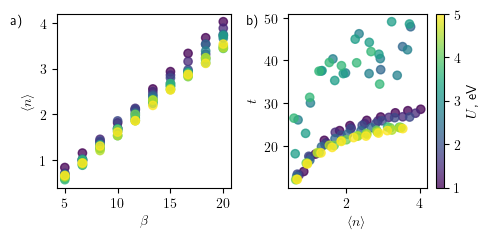

In [31]:
fig, (bx, cx) = plt.subplots(  1, 2, figsize=( 5,2.5), dpi=100)

# ax.scatter(U*beta, time, alpha=0.4)
# ax.set_xlabel(r'$U \beta$')
# ax.set_ylabel(r'$t$')

# bx.scatter(U, time)
# for u in Us:
#     c = u/Us[-1]
#     print(c)
#     bx.scatter(beta, order, label=rf'$U = {u:.1f}$ eV', color=(c,0,1-c), alpha=0.75)


aa = bx.scatter(beta, order, c= U, alpha=0.75) #(np.reshape(U, (10, 10)).T).flatten()
# colorbaraa = fig.colorbar(aa, ax=bx)
# colorbaraa.set_label(r'$U$, eV')
# color_bar = fig.colorbar(pos_neg_clipped,  
#                          ax = ax3, 
#                          extend = 'both') 
# bx.legend()
bx.set_xlabel(r'$\beta$')
bx.set_ylabel(r'$\langle n \rangle$')
bx.text(-0.2, 1.0, 'a)', transform=bx.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
cc = cx.scatter(order, times, c=U, alpha=0.75)
colorbarcc = fig.colorbar(cc, ax=cx)
colorbarcc.set_label(r'$U$, eV')


cx.set_xlabel(r'$\langle n \rangle$')
cx.set_ylabel(r'$t$')
cx.text(-0.2, 1.0, 'b)', transform=cx.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    

fig.tight_layout()
plt.savefig('./scaling_U.pdf', dpi=200, bbox_inches='tight')

fig.show()


# Detail analysis

In [39]:


s = Sample.sample(beta=20.0,U=4.0, BS=BS)
s.solve_impurity()
# s.plotBS()
print(s.time2solve, s.averageorder)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.00383157*c_dag('down',0)*c('down',0) + 0.00383157*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
14:28:47   0% ETA 00:00:21 cycle 45 of 10000
14:28:49   9% ETA 00:00:19 cycle 986 of 10000
14:28:52  21% ETA 00:00:17 cycle 2115 of 10000
14:28:55  35% ETA 00:00:14 cycle 3534 of 10000
14:28:59  53% ETA 00:00:10 cycle 5304 of 10000
14:29:04  75% ETA 00:00:05 cycle 7562 of 10000
14:29:09 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
14:29:09   9% ETA 00:00:00 cycle 45 of 500
14:29:10 100% ETA 00:00:00 cycle 499 of 500


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.000978217
Average o

In [57]:
G_iw_ML, GtauML, Gl_ML = predict_G(s)

ntau = 200
taumesh = np.linspace(0, s.beta, ntau)
G0_rebinned = s.G0_tau.rebinning_tau(new_n_tau=ntau)
G_rebinned = s.G_tau.rebinning_tau(new_n_tau=ntau)
GML_rebinned = GtauML.rebinning_tau(new_n_tau=ntau)


A0ens, A0       =  get_Gw(G0_rebinned)
Aens, A         =  get_Gw(G_rebinned)
Aens_ML, A_ML   =  get_Gw(GML_rebinned)

2024-09-05 14:35:05.680526
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 6.951032808128516
scaling alpha by a factor 200 (number of data points)
alpha[ 0] =   4.00000000e+03, chi2 =   3.82913502e+02, n_iter=      29 
alpha[ 1] =   2.10406142e+03, chi2 =   2.19930535e+02, n_iter=      10 
alpha[ 2] =   1.10676861e+03, chi2 =   1.27903083e+02, n_iter=      14 
alpha[ 3] =   5.82177283e+02, chi2 =   8.04938846e+01, n_iter=      15 
alpha[ 4] =   3.06234190e+02, chi2 =   5.82544075e+01, n_iter=      16 
alpha[ 5] =   1.61083886e+02, chi2 =   4.86906917e+01, n_iter=      21 
alpha[ 6] =   8.47325973e+01, chi2 =   4.48046598e+01, n_iter=    

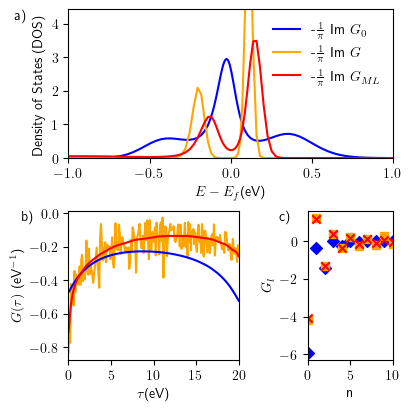

In [78]:


plot_all(s, A0ens, A0, Aens, A, Aens_ML, A_ML)
